# Fundamentals of Software Systems (FSS)
**Software Evolution – Part 02 Assignment**

## Submission Guidelines

To correctly complete this assignment you must:

* Carry out the assignment in a team of 2 to 4 students.
* Carry out the assignment with your team only. You are allowed to discuss solutions with other teams, but each team should come up its own personal solution. A strict plagiarism policy is going to be applied to all the artifacts submitted for evaluation.
* As your submission, upload the filled Jupyter Notebook (including outputs) together with the d3 visualization web pages (i.e. upload everything you downloaded including the filled Jupyter Notebook plus your `output.json`)
* The files must be uploaded to OLAT as a single ZIP (`.zip`) file by 2024-12-02 18:00.


## Group Members
* Kevin, Bruendler, 19-919-273

## Task Context

In this assigment we will be analyzing the _[Nautilus trader](https://nautilustrader.io/)_ project. The git repository is available here: https://github.com/nautechsystems/nautilus_trader 

All following tasks should be done with the subset of commits from tag `v1.165.0` to tag `v1.206.0`.

In [1]:
###############
# SETUP
###############

import os
import subprocess
from tqdm.notebook import tqdm
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s | %(levelname)s | %(message)s')

nautilus_repo = "https://github.com/nautechsystems/nautilus_trader"
clone_dir = os.path.join(os.getcwd(), "nautilus_trader")

if not os.path.exists(clone_dir):
    with tqdm(total=100, desc="Cloning Nautilus repo", unit="chunk") as progress_bar:
        process = subprocess.Popen(
            ['git', 'clone', '--progress', nautilus_repo, clone_dir],
            stderr=subprocess.PIPE,
            stdout=subprocess.DEVNULL,
            text=True
        )
        for line in process.stderr:
            if "Receiving objects" in line:
                percentage = int(line.split("%")[0].split()[-1])
                progress_bar.n = percentage
                progress_bar.refresh()
            elif "Resolving deltas" in line:
                progress_bar.set_description("Resolving deltas")
                progress_bar.refresh()
        process.wait()

    if process.returncode == 0:
        logging.info("cloning completed successfully")
    else:
        logging.error("error during cloning")
else:
    logging.warning("repo already cloned")

2024-11-26 20:22:14,949 | WARNING | repo already cloned


## Task 1: Author contributions

In the following, please consider only Rust, Python, and Cython (pyx and pxd) files.

The first task is to get an overview of the author ownership of the Nautilus Trader project. In particular, we want to understand who are the main authors in the system between the two considered tags and what is the amount of their contributions both in absolute terms and in percentages. We also want to investigate if the same patterns apply on the various subsystems.

To this end, you should:
* extract all the contributions between the two tags. If an author committed a file 3 times, then the number of contributions of that author on that file is 3
* sort the authors by total number of contributions, define a threshold and from now on consider only the authors above the threshold
* consider the following subsystems: nautilus_core and all the directories inside nautilus_trader (e.g., accounting, adapters, analysis, ...)
* for the considered authors and the considered subsystems, create a matrix (for example a pandas dataframe) where the columns are the authors, the rows the subsystems, and the value of a cell is the number of contribution of that author on that subsystem
* now comment on the results: is the main author predominant in terms of contributions? how are the contributions distributed among the authors? are the subsystems similar in terms of distribution? To answer these questions compute an additional column that measure the percentage of contributions of the main author with respect to the total.
* redo all the previous steps but instead of counting the number of contributions, for every file in every commit, count the number of lines added. Produce a matrix equivalent to the previous one, using the lines added and comment on the results. Are the results the same if we look at the lines added instead of the number of contributions? For which subsystems are the results different?





In [2]:
############################
# MINING COMMIT HISTORY
############################

import pydriller
from collections import defaultdict

from_tag = "v1.165.0"
to_tag = "v1.206.0"
file_extensions = (".rs", ".py", ".pyx", ".pxd")

logging.getLogger().setLevel(logging.CRITICAL)

author_contributions = defaultdict(lambda: defaultdict(int)) 

try:
    commits_data = []
    for commit in pydriller.Repository(clone_dir, from_tag=from_tag, to_tag=to_tag).traverse_commits():
        
        for mod in commit.modified_files:
            if mod.filename.endswith(file_extensions):
                author_contributions[commit.author.name][mod.filename] += 1
    
finally:
    logging.getLogger().setLevel(logging.INFO)

In [3]:
############################
# AUTHOR CONTRIBUTIONS
############################

MIN_THRESHOLD = 10

total_contributions = {author: sum(files.values()) for author, files in author_contributions.items()}
sorted_total_contributions = {author: total for author, total in sorted(total_contributions.items(), key=lambda x: x[1], reverse=True)}
selected_contributors = {author: total for author, total in sorted_total_contributions.items() if total >=MIN_THRESHOLD}

print("\nSelected Authors (Total Contributions >= {}):".format(MIN_THRESHOLD))
print("{:<25} {:>15}".format("Author", "Contributions"))
print("-" * 42)
for author, contributions in selected_contributors.items():
    print("{:<25} {:>15}".format(author, contributions))
print("-" * 42)    


Selected Authors (Total Contributions >= 10):
Author                      Contributions
------------------------------------------
Chris Sellers                       14465
Filip Macek                          1326
Ishan Bhanuka                         523
Pushkar Mishra                        389
Brad                                  306
David Blom                            224
rsmb7z                                182
faysou                                172
Benjamin Singleton                     87
limx0                                  83
Miller Moore                           63
DevRoss                                21
graceyangfan                           18
Ayush                                  13
Javaid                                 13
Ayush Singh Bhandari                   10
sunlei                                 10
------------------------------------------


In [4]:
############################
# SUBSYSTEM IDENTIFICATION
############################

nautilus_core_path = os.path.join(clone_dir, 'nautilus_core')
nautilus_trader_path = os.path.join(clone_dir, 'nautilus_trader')

subsystems = ['nautilus_core']

# Subdirectories inside nautilus_trader directory
for item in os.listdir(nautilus_trader_path):
    item_path = os.path.join(nautilus_trader_path, item)
    if os.path.isdir(item_path):
        subsystems.append(item)

print("\nSubsystems:")
for subsystem in subsystems:
    print(f"- {subsystem}")


Subsystems:
- nautilus_core
- accounting
- core
- analysis
- cache
- config
- indicators
- serialization
- test_kit
- backtest
- adapters
- system
- common
- execution
- examples
- live
- persistence
- model
- portfolio
- data
- trading
- risk


In [5]:
############################
# COMMIT MINING SUBSYSTEMS
############################
import pandas as pd

subsystem_contributions = defaultdict(lambda: defaultdict(int))
subsystem_addedlines = defaultdict(lambda: defaultdict(int))

logging.getLogger().setLevel(logging.CRITICAL)

try:
    for commit in pydriller.Repository(clone_dir, from_tag=from_tag, to_tag=to_tag).traverse_commits():
        author = commit.author.name
        
        if author not in selected_contributors:
            continue
            
        for mod in commit.modified_files:
            if mod.filename and mod.filename.endswith(file_extensions):
                filepath = mod.new_path or mod.old_path
                
                if filepath is None:
                    continue
                
                subsystem = None
                if 'nautilus_core' in filepath:
                    subsystem = 'nautilus_core'
                    
                elif 'nautilus_trader' in filepath:
                    parts = filepath.split(os.sep)
                    
                    try:
                        idx = parts.index('nautilus_trader')
                        
                        if idx + 1 < len(parts):
                            subsystem_candidate = parts[idx + 1]
                            
                            if subsystem_candidate in subsystems:
                                subsystem = subsystem_candidate
                                
                    except ValueError:
                        continue
                        
                if subsystem:
                    subsystem_contributions[subsystem][author] += 1
                    subsystem_addedlines[subsystem][author] += mod.added_lines
                    
except Exception as e:
    logging.error(f"Error during processing: {e}")
    
finally:
    logging.getLogger().setLevel(logging.INFO)


In [6]:
############################
# MATRIX CREATION - #COMMITS
############################
df_contributions = pd.DataFrame(subsystem_contributions).fillna(0).astype(int).transpose()

df_contributions['Total'] = df_contributions.sum(axis=1)
df_contributions['MainAuthor'] = df_contributions.drop('Total', axis=1).idxmax(axis=1)
df_contributions['MainAuthorContrib'] = df_contributions.apply(lambda row: row[row['MainAuthor']], axis=1)
df_contributions['MainAuthorPct'] = round((df_contributions['MainAuthorContrib'] / df_contributions['Total']) * 100,2)

cols = df_contributions.columns.tolist()
cols = [col for col in cols if col not in ['Total', 'MainAuthor', 'MainAuthorContrib', 'MainAuthorPct']]
df_contributions = df_contributions[cols + ['Total', 'MainAuthor', 'MainAuthorContrib', 'MainAuthorPct']]

In [7]:
df_contributions

,Chris Sellers,Brad,rsmb7z,DevRoss,Ishan Bhanuka,Filip Macek,Ayush Singh Bhandari,David Blom,Ayush,Pushkar Mishra,...,Benjamin Singleton,limx0,graceyangfan,Javaid,sunlei,Miller Moore,Total,MainAuthor,MainAuthorContrib,MainAuthorPct
examples,194,4,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,203,Chris Sellers,194,95.57
nautilus_core,6545,0,12,0,472,987,10,8,10,384,...,0,0,0,0,0,0,8458,Chris Sellers,6545,77.38
adapters,1831,88,54,15,14,67,0,162,0,0,...,60,12,2,9,9,63,2393,Chris Sellers,1831,76.51
core,213,1,1,0,4,0,0,0,0,0,...,0,0,0,0,0,0,228,Chris Sellers,213,93.42
portfolio,35,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,37,Chris Sellers,35,94.59
common,327,0,0,0,5,2,0,5,0,0,...,0,0,2,0,0,0,354,Chris Sellers,327,92.37
model,724,10,10,0,1,46,0,0,0,0,...,0,5,0,0,0,0,808,Chris Sellers,724,89.60
execution,269,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,272,Chris Sellers,269,98.90
system,72,2,0,0,2,0,0,0,0,0,...,0,0,1,0,0,0,80,Chris Sellers,72,90.00
live,189,0,1,0,0,2,0,1,0,0,...,1,0,1,0,0,0,196,Chris Sellers,189,96.43


##### COMMENT: NUMBER COMMITS PER AUTHOR
As can be seen from the dataframe (df_contributions), the main contributor in terms of commits is unanimously Chris Sellers. In nautilus_core his contribution share is 77.38%, whereas in the subdirectories of nautilus_trader, his contribution share ranges from 69.44% (test_kit) to 100% (analysis).

In [8]:
############################
# MATRIX CREATION - #+LINES
############################
df_addlines = pd.DataFrame(subsystem_addedlines).fillna(0).astype(int).transpose()

df_addlines['Total'] = df_addlines.sum(axis=1)
df_addlines['MainAuthor'] = df_addlines.drop('Total', axis=1).idxmax(axis=1)
df_addlines['MainAuthorContrib'] = df_addlines.apply(lambda row: row[row['MainAuthor']], axis=1)
df_addlines['MainAuthorPct'] = round((df_addlines['MainAuthorContrib'] / df_addlines['Total']) * 100,2)

cols = df_addlines.columns.tolist()
cols = [col for col in cols if col not in ['Total', 'MainAuthor', 'MainAuthorContrib', 'MainAuthorPct']]
df_addlines = df_addlines[cols + ['Total', 'MainAuthor', 'MainAuthorContrib', 'MainAuthorPct']]

In [9]:
df_addlines

,Chris Sellers,Brad,rsmb7z,DevRoss,Ishan Bhanuka,Filip Macek,Ayush Singh Bhandari,David Blom,Ayush,Pushkar Mishra,...,Benjamin Singleton,limx0,graceyangfan,Javaid,sunlei,Miller Moore,Total,MainAuthor,MainAuthorContrib,MainAuthorPct
examples,1157,22,194,362,0,0,0,0,0,0,...,0,0,0,0,0,0,1735,Chris Sellers,1157,66.69
nautilus_core,112980,0,561,0,9938,45489,799,59,450,18184,...,0,0,0,0,0,0,189748,Chris Sellers,112980,59.54
adapters,24370,1448,2423,190,106,5251,0,8407,0,0,...,4347,191,43,48,20,8818,56053,Chris Sellers,24370,43.48
core,2664,2,11,0,51,0,0,0,0,0,...,0,0,0,0,0,0,2893,Chris Sellers,2664,92.08
portfolio,286,0,27,0,0,13,0,0,0,0,...,0,0,0,0,0,0,326,Chris Sellers,286,87.73
common,7046,0,0,0,89,21,0,30,0,0,...,0,0,71,0,0,0,7572,Chris Sellers,7046,93.05
model,15416,55,530,0,2,347,0,0,0,0,...,0,26,0,0,0,0,16918,Chris Sellers,15416,91.12
execution,3113,1,0,0,3,7,0,0,0,0,...,0,0,0,0,0,0,3124,Chris Sellers,3113,99.65
system,911,26,0,0,29,0,0,0,0,0,...,0,0,7,0,0,0,1000,Chris Sellers,911,91.10
live,1855,0,2,0,0,18,0,32,0,0,...,1,0,27,0,0,0,1939,Chris Sellers,1855,95.67


##### COMMENT: NUMBER LINES ADDED PER AUTHOR
As can be seen from the dataframe (df_addlines), the main author in terms of lines added mostly remains Chris Sellers. However, in the submodule nautilus_trader/indicators, the main contributor in terms of lines added is "rsmb7z" with 66.62% contribution share and in the submodule nautilus_trader/risk it is "faysou" with a contribution share of 70.71%.

In all remaining submodules, Chris Sellers is the main author. His contribution share for nautilus_core in terms of added lines is at 59.54% and in the submodules for nautilus_trader where he is the main contributor, his share ranges from 43.48% (adapters) to 100.00% (analysis).



## Task 2: Knowledge loss

We now want to analyze the knowledge loss when the main contributor of the analyzed project would leave. For this we will use the circle packaging layout introduced in the "Code as a Crime Scene" book. This assignment includes the necessary `knowledge_loss.html` file as well as the `d3` folder for all dependencies. Your task is to create the `output.json` file according to the specification below. This file can then be visualized with the files provided.

For showing the visualization, once you have the output as `output.json` you should

* make sure to have the `knowledge_loss.html` file in the same folder
* start a local HTTP server in the same folder (e.g. with python `python3 -m http.server`) to serve the html file (necessary for d3 to work)
* open the served `knowledge_loss.html` and look at the visualization

Based on the visualization, comment on how is the project in terms of project loss and what could happen if the main contributor would leave.


### Output Format for Visualization

* `root` is always the root of the tree
* `size` should be the total number of lines of contribution
* `weight` can be set to the same as `size`
* `ownership` should be set to the percentage of contributions from the main author (e.g. 0.98 for 98% if contributions coming from the main author)

```
{
  "name": "root",
  "children": [
    {
      "name": "test",
      "children": [
        {
          "name": "benchmarking",
          "children": [
            {
              "author_color": "red",
              "size": "4005",
              "name": "t6726-patmat-analysis.scala",
              "weight": 1.0,
              "ownership": 0.9,
              "children": []
            },
            {
              "author_color": "red",
              "size": "55",
              "name": "TreeSetIterator.scala",
              "weight": 0.88,
              "ownership": 0.9,
              "children": []
            }
          ]
        }
      ]
    }
  ]
}
```

### JSON Export

For exporting the data to JSON you can use the following snippet:

```
import json

with open("output.json", "w") as file:
    json.dump(tree, file, indent=4)
```

In [10]:
############################
# PROCESS COMMIT HISTORY
############################

file_authors_lines = defaultdict(lambda: defaultdict(int))

logging.getLogger().setLevel(logging.CRITICAL)

for commit in pydriller.Repository(clone_dir, from_tag=from_tag, to_tag=to_tag).traverse_commits():
    author = commit.author.name
    for mod in commit.modified_files:
        filepath = mod.new_path or mod.old_path
        if filepath is None:
            continue
        if not filepath.endswith(file_extensions):
            continue
        added_lines = mod.added_lines
        if added_lines > 0:
            file_authors_lines[filepath][author] += added_lines

logging.getLogger().setLevel(logging.INFO)

In [12]:
############################
# COMPUTE OWNERSHIP
############################

import matplotlib.colors as mcolors
import matplotlib.cm as cm

authors = set()
for author_lines in file_authors_lines.values():
    authors.update(author_lines.keys())
    
colormap = cm.get_cmap('hsv', len(authors))

author_colors = {}
for idx, author in enumerate(sorted(authors)):
    color = mcolors.rgb2hex(colormap(idx))
    author_colors[author] = color

In [13]:
############################
# BUILD DIRECTORY TREE
############################
import json

tree = {"name": "root", "children": []}

def insert_file_into_tree(tree_node, filepath_parts, file_info):
    if not filepath_parts:
        return
    part = filepath_parts[0]

    child_node = next((child for child in tree_node.get("children", []) if child["name"] == part), None)
    if child_node is None:

        child_node = {"name": part}
        if len(filepath_parts) == 1:

            child_node.update({
                "size": str(file_info["size"]),
                "weight": file_info["weight"],
                "ownership": round(file_info["ownership"], 2),
                "author_color": file_info["author_color"],
                "children": []
            })
            
        else:
            child_node["children"] = []
        tree_node.setdefault("children", []).append(child_node)

    if len(filepath_parts) > 1:
        insert_file_into_tree(child_node, filepath_parts[1:], file_info)

for filepath, author_lines in file_authors_lines.items():
    total_lines = sum(author_lines.values())
    if total_lines == 0:
        continue
        
    main_author = max(author_lines, key=author_lines.get)
    main_author_lines = author_lines[main_author]
    ownership = main_author_lines / total_lines
    file_info = {
        "size": total_lines,
        "weight": total_lines,
        "ownership": ownership,
        "author_color": author_colors[main_author]
    }

    filepath_parts = filepath.strip(os.sep).split(os.sep)

    insert_file_into_tree(tree, filepath_parts, file_info)
    
with open("output.json", "w") as file:
    json.dump(tree, file, indent=4)

## Task 3: Code Churn Analysis

The third and last task is to analyze the code churn of the _Nautilus Trader_ project. For this analysis we look at the code churn, meaning the daily change in the total number of lines of the project.

Visualize the code churn over time bucketing the data by day. Remember that you'll need to consider also the days when there are no commits.

Look at the churn trend over time, identify one outlier of your choice, and for it:

* investigate if it was caused by a single or multiple commits (since you are bucketing the data by day)
* find the involved commit(s) and look at the commit message(s)
* find the involved files, and for each file look at the number of lines added and/or deleted as well as the modification type (addition, deletion, modification, renaming)

Based on the above, discuss the potential reasons for the outlier and if it should be a reason for concern.

In [14]:
############################
# COMMIT MINING CHURN
############################

from_tag = "v1.165.0"
to_tag = "v1.206.0"

logging.getLogger().setLevel(logging.CRITICAL)

lines_added = defaultdict(int) 
lines_deleted = defaultdict(int)

try:
    commits_data = []
    for commit in pydriller.Repository(clone_dir, from_tag=from_tag, to_tag=to_tag).traverse_commits():
        
        for mod in commit.modified_files:
            lines_added[commit.committer_date.date()] += mod.added_lines
            lines_deleted[commit.committer_date.date()] += mod.deleted_lines
                    
finally:
    logging.getLogger().setLevel(logging.INFO)

In [15]:
############################
# DATAFRAME AND REINDEXING
############################

df_churn = pd.DataFrame({
    'Date': list(lines_added.keys()),
    'Lines Added': list(lines_added.values()),
    'Lines Deleted': list(lines_deleted.values())
})

# Date Interpolation through reindexing
df_churn.set_index('Date', inplace=True)
df_churn = df_churn.reindex(pd.date_range(start=df_churn.index.min(), end=df_churn.index.max(), freq='D'), fill_value=0)

df_churn['Total Lines Changed'] = df_churn['Lines Added'].abs() + df_churn['Lines Deleted'].abs()

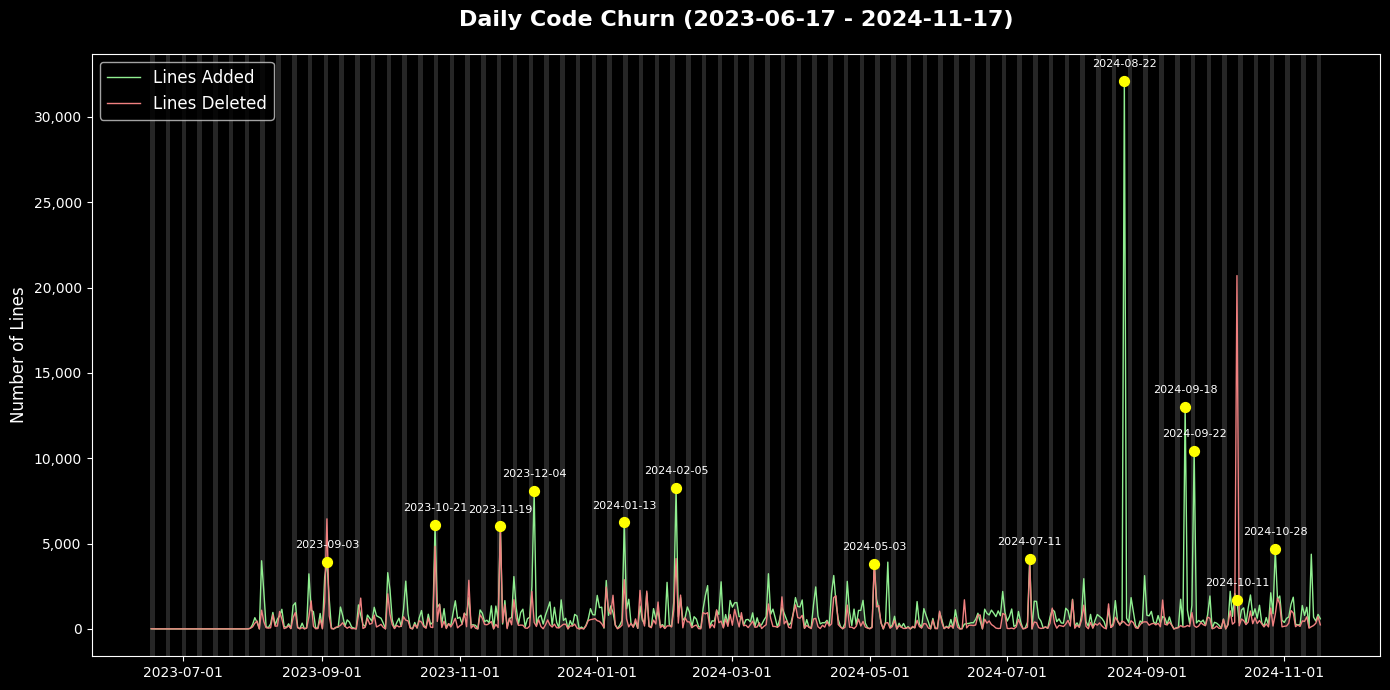

In [16]:
############################
# VISUALIZATION
############################

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(df_churn.index, df_churn['Lines Added'], label='Lines Added', color='lightgreen', linewidth=1)
ax.plot(df_churn.index, df_churn['Lines Deleted'], label='Lines Deleted', color='lightcoral', linewidth=1)

# Outlier highlighting and Annotation
threshold = df_churn['Total Lines Changed'].quantile(0.975)
outliers = df_churn[df_churn['Total Lines Changed'] >= threshold]
ax.scatter(outliers.index, outliers['Lines Added'], color='yellow', s=50, zorder=5)

for idx, row in outliers.iterrows():
    ax.annotate(
        idx.strftime('%Y-%m-%d'),
        (mdates.date2num(idx), row['Lines Added']),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        color='white',
        fontsize=8
    )

ax.set_title(f'Daily Code Churn ({df_churn.index[0].date()} - {df_churn.index[-1].date()})', fontsize=16, color='white', pad=20, fontweight="bold")
ax.set_ylabel('Number of Lines', fontsize=12, color='white')

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend(loc='upper left', fontsize=12)

# Weekend highlighting
for idx in df_churn.index:
    if idx.weekday() >= 5:
        ax.axvspan(idx - pd.Timedelta(hours=12), idx + pd.Timedelta(hours=12), facecolor='gray', alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
############################
# OUTLIER ANALYSIS
############################

from datetime import timedelta

selected_commit_date = pd.to_datetime("2024-08-22")

logging.getLogger().setLevel(logging.CRITICAL)

outlier_commits = [
    c for c in pydriller.Repository(
        clone_dir,
        since=selected_commit_date - timedelta(days=1),
        to=selected_commit_date + timedelta(days=1),
    ).traverse_commits()
    if c.committer_date.date() == selected_commit_date.date()
]

logging.getLogger().setLevel(logging.INFO)

print(f"Commits on {selected_commit_date.date()}:")
print("-" * 60)
for commit in outlier_commits:
    lines_added = sum(mod.added_lines for mod in commit.modified_files)
    lines_deleted = sum(mod.deleted_lines for mod in commit.modified_files)
    
    print(f"Commit Hash    : {commit.hash}")
    print(f"Author         : {commit.author.name}")
    print(f"Message        : {commit.msg.strip()}")
    print(f"Date           : {commit.committer_date}")
    print(f"Lines Added    : {lines_added}")
    print(f"Lines Deleted  : {lines_deleted}")
    print("-" * 60)
    
    print(f"Files Modified: {len([mod for mod in commit.modified_files])}")
    for mod in commit.modified_files:
        print(f"  - File Path       : {mod.new_path or mod.old_path}")
        print(f"    Change Type     : {mod.change_type.name}")
        print(f"    Lines Added     : {mod.added_lines}")
        print(f"    Lines Deleted   : {mod.deleted_lines}")
    print("=" * 80)

Commits on 2024-08-22:
------------------------------------------------------------
Commit Hash    : a0694c616b8b164d0490931614616b6d245593f4
Author         : Chris Sellers
Message        : Fix OrderBook memory deallocation from Python

Memory was not being freed on object destruction.
Date           : 2024-08-22 18:06:19+10:00
Lines Added    : 6
Lines Deleted  : 1
------------------------------------------------------------
Files Modified: 2
  - File Path       : RELEASES.md
    Change Type     : MODIFY
    Lines Added     : 1
    Lines Deleted   : 1
  - File Path       : nautilus_trader/model/book.pyx
    Change Type     : MODIFY
    Lines Added     : 5
    Lines Deleted   : 0
Commit Hash    : b9b06a0d40ebcf7fd897bd6cdf76c73098678bda
Author         : Ishan Bhanuka
Message        : Improve error handling by refactoring result type and unwraps (#1866)
Date           : 2024-08-22 18:17:51+10:00
Lines Added    : 868
Lines Deleted  : 326
---------------------------------------------------

#### COMMENT: CHURN ANALYSIS
For the churn analysis, I selected the 2024-08-22 as the date to be analysed. There were 5 commits on that date, with the bulk of the changes coming from commit "1ac7dde8f8cba3067b0055929afe1782fce09dc5" by David Blom that added a staggering 31,022 lines with the message "Initial dYdX v4 adapter (#1861)". In this commit, 92 files were modified.

Upon research, it seems that within this commit, a new exchange version (https://dydx.exchange/) was onboarded. The number of files changed along with the total number of additions makes this a very challenging commit from a review perspective. However, a very large part of the added lines went into testing as can be seen for example by the added 13,011 lines to the tests/test_data/dydx/websocket/v4_candles.json file. While the amount of lines suggests a high test coverage, it is by no means a guaranteed that the tests are thorough. As such, the commit would still require careful investigation in my opinion as it could be problematic.   